In [ ]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

!pip install catboost optuna -qq


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import RobustScaler
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN

from sklearn.metrics import (
    roc_auc_score, classification_report,
    confusion_matrix, f1_score, precision_score, recall_score,
    precision_recall_curve, accuracy_score
)
!pip install lime shap keras-tuner
import lime
import lime.lime_tabular
import shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.9 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=69b1a1e2f11907154fa33bbe86159935d5e38091e54db3d36cc2a1892575e1f5
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
train_df = pd.read_csv('Train.csv')
test_df = pd.read_csv('Test.csv')
train_df.head()

ID   Loan_ID  Gender  Married Dependents  Education  Self_Employed  \
0  74768  LP002231       1        1          0          1              0   
1  79428  LP001448       1        1          0          0              0   
2  70497  LP002231       0        0          0          0              0   
3  87480  LP001385       1        1          0          0              0   
4  33964  LP002231       1        1          1          0              0   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             8328           0.000000          17               363   
1              150        3857.458782         188               370   
2             4989         314.472511          17               348   
3              150           0.000000         232               359   
4             8059           0.000000          17               372   

   Credit_History  Property_Area  Loan_Status  Total_Income  
0               1              2            1          6000  
1               1              1            0          6000  
2               1              0            0          6000  
3               1              1            1          3750  
4               1              0            1          3750

In [ ]:
print(f'missing values in train: \n{train_df.isnull().sum()}')
print(f'missing values in test: \n{test_df.isnull().sum()}')

missing values in train: 
ID                   0
Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
Total_Income         0
dtype: int64
missing values in test: 
ID                   0
Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Total_Income         0
dtype: int64


In [ ]:
target = train_df['Loan_Status']
print(f'target distribution:\n', train_df['Loan_Status'].value_counts())

target distribution:
 Loan_Status
1    4913
0     985
Name: count, dtype: int64


FEATURE ENGINEERING && PREPROCESSING

In [ ]:
train_df['source']= 'train'
test_df['source']= 'test'
combined_df = pd.concat([train_df, test_df], ignore_index=True)
print(combined_df.head())

print(combined_df['source'].value_counts())

      ID   Loan_ID  Gender  Married Dependents  Education  Self_Employed  \
0  74768  LP002231       1        1          0          1              0   
1  79428  LP001448       1        1          0          0              0   
2  70497  LP002231       0        0          0          0              0   
3  87480  LP001385       1        1          0          0              0   
4  33964  LP002231       1        1          1          0              0   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             8328           0.000000          17               363   
1              150        3857.458782         188               370   
2             4989         314.472511          17               348   
3              150           0.000000         232               359   
4             8059           0.000000          17               372   

   Credit_History  Property_Area  Loan_Status  Total_Income source  
0               1              2          1.0  

In [ ]:
def col_to_lower_case(df):
  df.columns = [col.lower() for col in df.columns]
  return df

col_to_lower_case(combined_df)
col_to_lower_case(train_df)
col_to_lower_case(test_df)

id   loan_id  gender  married dependents  education  self_employed  \
0     70607  LP002560       1        1          0          1              0   
1     58412  LP001379       1        1          0          0              1   
2     88755  LP002560       0        0          0          0              0   
3     97271  LP002560       1        1          0          0              0   
4     70478  LP002231       1        1          0          0              0   
...     ...       ...     ...      ...        ...        ...            ...   
2523  15578  LP002175       1        1          0          0              0   
2524  87689  LP002582       1        1          0          0              1   
2525  42584  LP002231       1        1          0          0              0   
2526  44709  LP002224       1        1          0          0              0   
2527  75533  LP002139       0        1          0          1              0   

      applicantincome  coapplicantincome  loanamount  loan_amount_term  \
0               15890         871.075952         188               371   
1                6582         896.718887          17               373   
2                7869         572.900354          17               373   
3                 150           0.000000         247               349   
4                8362           0.000000          17                12   
...               ...                ...         ...               ...   
2523             7276           0.000000         168               367   
2524             8153        1585.948119          17               406   
2525            16382         600.813513          17               348   
2526             7791           0.000000          78               350   
2527            12208          71.622122         101               372   

      credit_history  property_area  total_income source  
0                  1              1          6000   test  
1                  0              1          6000   test  
2                  1              1          6000   test  
3                  1              2          6000   test  
4                  1              2          3750   test  
...              ...            ...           ...    ...  
2523               1              1          3750   test  
2524               1              1          3750   test  
2525               1              2          3750   test  
2526               0              1          3750   test  
2527               1              1          3750   test  

[2528 rows x 15 columns]

In [ ]:
combined_df['dependents'] = combined_df['dependents'].str.replace('+', '', regex=False)
dependents_dummies = pd.get_dummies(combined_df['dependents'], prefix='dependents')
combined_df = pd.concat([combined_df, dependents_dummies], axis=1)
combined_df = combined_df.drop('dependents', axis=1)

In [ ]:
def feature_eng(df):
    df['total_income'] = df['applicantincome'] + df['coapplicantincome']
    df['loan_repayment_rate'] = df['loanamount'] / df['loan_amount_term']
    df['loan_amount_ratio'] = df['loanamount'] / df['applicantincome']
    df['loan_to_income_ratio'] = df['loanamount'] / df['total_income']
    df['loan_repayment_income_ratio'] = df['loan_repayment_rate'] / df['total_income']
    df['loan_repayment_applicatnt_income_ratio'] = df['loan_repayment_rate'] / df['applicantincome']
    df['loan_income_thru_term'] = df['applicantincome'] * df['loan_amount_term']
    df['loan_term_income_ratio'] = df['loan_amount_term'] / df['total_income']
    # df['tota_income_to_dependent_ratio'] = df['total_income'] / (df['dependents'] + 1)

    return df

combined_df = feature_eng(combined_df)

In [ ]:
combined_df.head()

id   loan_id  gender  married  education  self_employed  \
0  74768  LP002231       1        1          1              0   
1  79428  LP001448       1        1          0              0   
2  70497  LP002231       0        0          0              0   
3  87480  LP001385       1        1          0              0   
4  33964  LP002231       1        1          0              0   

   applicantincome  coapplicantincome  loanamount  loan_amount_term  ...  \
0             8328           0.000000          17               363  ...   
1              150        3857.458782         188               370  ...   
2             4989         314.472511          17               348  ...   
3              150           0.000000         232               359  ...   
4             8059           0.000000          17               372  ...   

   dependents_1  dependents_2  dependents_3  loan_repayment_rate  \
0         False         False         False             0.046832   
1         False         False         False             0.508108   
2         False         False         False             0.048851   
3         False         False         False             0.646240   
4          True         False         False             0.045699   

  loan_amount_ratio  loan_to_income_ratio  loan_repayment_income_ratio  \
0          0.002041              0.002041                     0.000006   
1          1.253333              0.046913                     0.000127   
2          0.003407              0.003205                     0.000009   
3          1.546667              1.546667                     0.004308   
4          0.002109              0.002109                     0.000006   

   loan_repayment_applicatnt_income_ratio  loan_income_thru_term  \
0                                0.000006                3023064   
1                                0.003387                  55500   
2                                0.000010                1736172   
3                                0.004308                  53850   
4                                0.000006                2997948   

   loan_term_income_ratio  
0                0.043588  
1                0.092328  
2                0.065617  
3                2.393333  
4                0.046160  

[5 rows x 26 columns]

In [ ]:
top_loan_applicants = train_df['loan_id'].value_counts().nlargest(30).index
combined_df['loan_id'] = np.where(combined_df['loan_id'].isin(top_loan_applicants), combined_df['loan_id'], 'other')

combined_df['loan_id'].value_counts()

loan_id
other       1833
LP002187    1095
LP002585    1066
LP002231    1028
LP002175     653
LP002224     522
LP002560     521
LP001385     155
LP001790     150
LP002582     150
LP002181     130
LP001369     103
LP001778     101
LP002571      98
LP002170      78
LP001448      76
LP002229      73
LP001844      67
LP002556      62
LP002180      58
LP002223      52
LP001384      48
LP002226      47
LP002555      45
LP001431      44
LP001835      35
LP002219      30
LP001788      30
LP002531      26
LP002209      25
LP002139      25
Name: count, dtype: int64

In [ ]:
# summary statistics for selected columns
summary_stats_list = []
for loan, loan_df in train_df.groupby('loan_id'):
    print(f'Loan ID: {loan}')
    summary_stats = {'loan_id': loan}
    summary_stats['mean_loan_amount'] = loan_df['loanamount'].mean()
    summary_stats['std_loan_amount'] = loan_df['loanamount'].std()

    summary_stats['mean_loan_status'] = loan_df['loan_status'].mean()
    summary_stats['count_loan_status'] = loan_df['loan_status'].count()
    summary_stats['std_loan_status'] = loan_df['loan_status'].std()
    summary_stats['sum_loan_status'] = loan_df['loan_status'].sum()
    summary_stats['count_rejected_loan_status'] = summary_stats['count_loan_status'] - summary_stats['sum_loan_status']

    summary_stats['mean_total_income'] = loan_df['total_income'].mean()
    summary_stats['std_total_income'] = loan_df['total_income'].std()

    summary_stats_list.append(summary_stats)

summary_stats_df = pd.DataFrame(summary_stats_list)
print(summary_stats_df)



Loan ID: LP001002
Loan ID: LP001003
Loan ID: LP001005
Loan ID: LP001008
Loan ID: LP001011
Loan ID: LP001013
Loan ID: LP001014
Loan ID: LP001018
Loan ID: LP001020
Loan ID: LP001024
Loan ID: LP001027
Loan ID: LP001028
Loan ID: LP001029
Loan ID: LP001030
Loan ID: LP001032
Loan ID: LP001034
Loan ID: LP001036
Loan ID: LP001038
Loan ID: LP001041
Loan ID: LP001043
Loan ID: LP001046
Loan ID: LP001050
Loan ID: LP001052
Loan ID: LP001066
Loan ID: LP001068
Loan ID: LP001073
Loan ID: LP001086
Loan ID: LP001087
Loan ID: LP001091
Loan ID: LP001095
Loan ID: LP001097
Loan ID: LP001098
Loan ID: LP001100
Loan ID: LP001106
Loan ID: LP001109
Loan ID: LP001112
Loan ID: LP001114
Loan ID: LP001119
Loan ID: LP001120
Loan ID: LP001123
Loan ID: LP001131
Loan ID: LP001136
Loan ID: LP001137
Loan ID: LP001138
Loan ID: LP001146
Loan ID: LP001151
Loan ID: LP001155
Loan ID: LP001157
Loan ID: LP001164
Loan ID: LP001179
Loan ID: LP001186
Loan ID: LP001194
Loan ID: LP001195
Loan ID: LP001197
Loan ID: LP001199
Loan ID: L

In [ ]:
combined_df = pd.merge(combined_df, summary_stats_df, on='loan_id', how='left')
combined_df.head()

id   loan_id  gender  married  education  self_employed  \
0  74768  LP002231       1        1          1              0   
1  79428  LP001448       1        1          0              0   
2  70497  LP002231       0        0          0              0   
3  87480  LP001385       1        1          0              0   
4  33964  LP002231       1        1          0              0   

   applicantincome  coapplicantincome  loanamount  loan_amount_term  ...  \
0             8328           0.000000          17               363  ...   
1              150        3857.458782         188               370  ...   
2             4989         314.472511          17               348  ...   
3              150           0.000000         232               359  ...   
4             8059           0.000000          17               372  ...   

   loan_term_income_ratio  mean_loan_amount  std_loan_amount  \
0                0.043588         90.486072       101.314398   
1                0.092328         97.529412        90.924662   
2                0.065617         90.486072       101.314398   
3                2.393333        121.628571       110.692424   
4                0.046160         90.486072       101.314398   

   mean_loan_status count_loan_status  std_loan_status  sum_loan_status  \
0          0.832869             718.0         0.373353            598.0   
1          0.843137              51.0         0.367290             43.0   
2          0.832869             718.0         0.373353            598.0   
3          0.857143             105.0         0.351605             90.0   
4          0.832869             718.0         0.373353            598.0   

   count_rejected_loan_status  mean_total_income  std_total_income  
0                       120.0        5178.746518       2000.770619  
1                         8.0        4888.019608       1169.832663  
2                       120.0        5178.746518       2000.770619  
3                        15.0        5213.266667       1740.030942  
4                       120.0        5178.746518       2000.770619  

[5 rows x 35 columns]

In [ ]:
train_df_preprocessed = combined_df[combined_df['source'] == 'train']
test_df_preprocessed = combined_df[combined_df['source'] == 'test']

In [ ]:
# Define features (X) for the training set and drop object columns
X = train_df_preprocessed.select_dtypes(exclude='object').drop(['id', 'loan_status'], axis=1)

# Define target variable (y)
y = train_df_preprocessed['loan_status']

# Handle missing values in X
impute_values = X.mean()
X.fillna(impute_values, inplace=True)

# Verify that there are no more NaNs in X
print("\nMissing values in X after imputation:")
print(X.isnull().sum())

print("Features (X) shape:", X.shape)
print("Target (y) shape:", y.shape)


Missing values in X after imputation:
gender                                    0
married                                   0
education                                 0
self_employed                             0
applicantincome                           0
coapplicantincome                         0
loanamount                                0
loan_amount_term                          0
credit_history                            0
property_area                             0
total_income                              0
dependents_0                              0
dependents_1                              0
dependents_2                              0
dependents_3                              0
loan_repayment_rate                       0
loan_amount_ratio                         0
loan_to_income_ratio                      0
loan_repayment_income_ratio               0
loan_repayment_applicatnt_income_ratio    0
loan_income_thru_term                     0
loan_term_income_ratio               

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42, stratify=y)

# Models

## Logistic Regression

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Model Evaluation:
Accuracy: 0.6644
Confusion Matrix:
[[ 61 136]
 [260 723]]
Precision: 0.8417
Recall: 0.7355
F1 Score: 0.7850
ROC AUC Score: 0.5274
Classification Report:


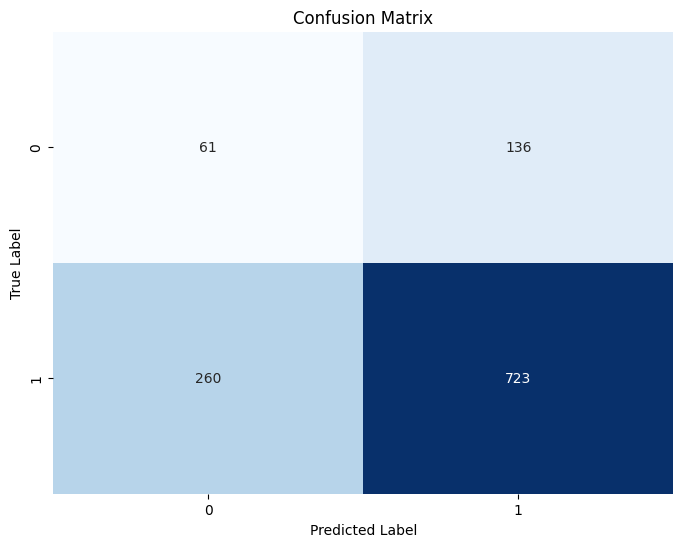


--- Logistic Regression Explanations (LIME and SHAP) ---

LIME explanation for instance 10 (Logistic Regression):


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



SHAP summary plot for Logistic Regression:


TypeError: loop of ufunc does not support argument 0 of type float which has no callable rint method

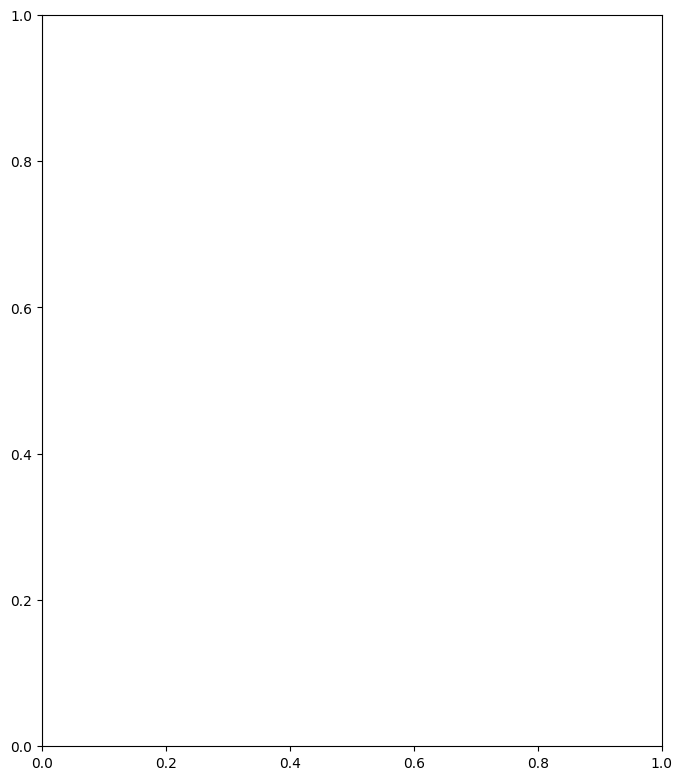

In [ ]:
# Initialize the Logistic Regression model
log_reg_model = LogisticRegression(class_weight = 'balanced', C = 1000, random_state=42)

# Train the model
log_reg_model.fit(X_train, y_train)

# Make predictions
y_pred = log_reg_model.predict(X_test)
y_pred_proba = log_reg_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1.0)
recall = recall_score(y_test, y_pred, pos_label=1.0)
f1 = f1_score(y_test, y_pred, pos_label=1.0)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)

print("Logistic Regression Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("Classification Report:")
class_report

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\n--- Logistic Regression Explanations (LIME and SHAP) ---")

# LIME Explanations for Logistic Regression
explainer_lr = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['0', '1'],
    discretize_continuous=True
)

# Explain an instance using LIME for Logistic Regression
i = 10  # Choose an instance index from the test set

def predict_fn_lr(x):
    probs = log_reg_model.predict_proba(x)
    return probs

exp_lr = explainer_lr.explain_instance(X_test.values[i], predict_fn_lr, num_features=10)
print(f"\nLIME explanation for instance {i} (Logistic Regression):")
exp_lr.show_in_notebook(show_table=True, show_all=False)


## XGBoost

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:37:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Model Evaluation:
Accuracy: 0.7924
Confusion Matrix:
[[  5 192]
 [ 53 930]]
Precision: 0.8289
Recall: 0.9461
F1 Score: 0.8836
ROC AUC Score: 0.4263
Classification Report:
              precision    recall  f1-score   support

         0.0       0.09      0.03      0.04       197
         1.0       0.83      0.95      0.88       983

    accuracy                           0.79      1180
   macro avg       0.46      0.49      0.46      1180
weighted avg       0.70      0.79      0.74      1180



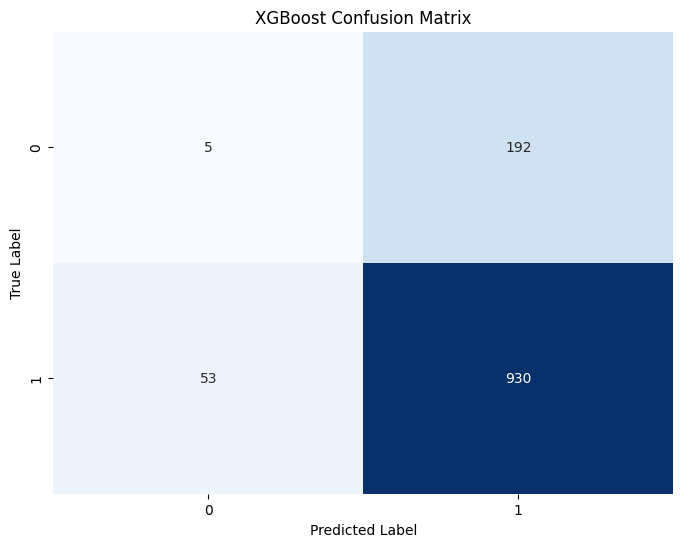

In [ ]:
# Initialize the XGBoost model
xgb_model = XGBClassifier(
    max_depth=6,
    random_state=42,
    n_estimators=600,
    learning_rate=0.04,
    scale_pos_weight=0.5,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, pos_label=1.0)
recall_xgb = recall_score(y_test, y_pred_xgb, pos_label=1.0)
f1_xgb = f1_score(y_test, y_pred_xgb, pos_label=1.0)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
class_report_xgb = classification_report(y_test, y_pred_xgb)

print("\nXGBoost Model Evaluation:")
print(f"Accuracy: {accuracy_xgb:.4f}")
print("Confusion Matrix:")
print(conf_matrix_xgb)
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"ROC AUC Score: {roc_auc_xgb:.4f}")
print("Classification Report:")
print(class_report_xgb)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\n--- XGBoost Explanations (LIME and SHAP) ---")

# LIME Explanations for XGBoost
explainer_xgb = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['0', '1'],
    discretize_continuous=True
)

def predict_fn_xgb(x):
    probs = xgb_model.predict_proba(x)
    return probs

exp_xgb = explainer_xgb.explain_instance(X_test.values[i], predict_fn_xgb, num_features=10)
print(f"\nLIME explanation for instance {i} (XGBoost):")
exp_xgb.show_in_notebook(show_table=True, show_all=False)



## RandomForest


Random Forest Model Evaluation:
Accuracy: 0.7178
Confusion Matrix:
[[ 17 180]
 [153 830]]
Precision: 0.8218
Recall: 0.8444
F1 Score: 0.8329
ROC AUC Score: 0.4160
Classification Report:
              precision    recall  f1-score   support

         0.0       0.10      0.09      0.09       197
         1.0       0.82      0.84      0.83       983

    accuracy                           0.72      1180
   macro avg       0.46      0.47      0.46      1180
weighted avg       0.70      0.72      0.71      1180



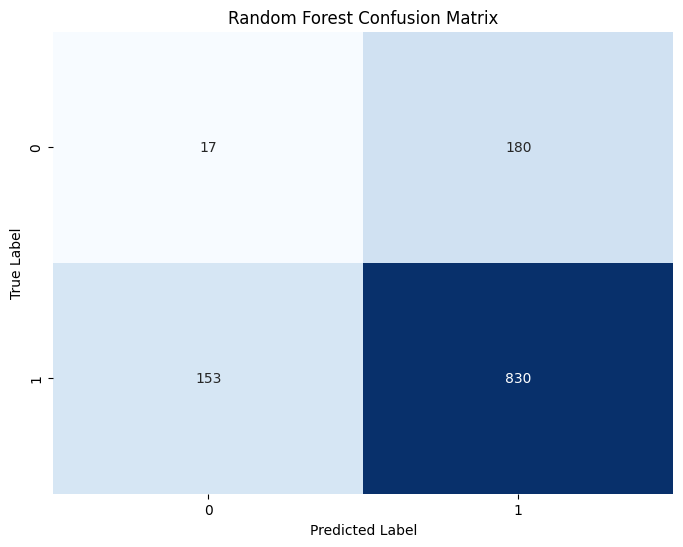

In [ ]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(
    max_depth=8,
    random_state=42,
    n_estimators=1000,
    class_weight='balanced'
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, pos_label=1.0)
recall_rf = recall_score(y_test, y_pred_rf, pos_label=1.0)
f1_rf = f1_score(y_test, y_pred_rf, pos_label=1.0)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
class_report_rf = classification_report(y_test, y_pred_rf)

print("\nRandom Forest Model Evaluation:")
print(f"Accuracy: {accuracy_rf:.4f}")
print("Confusion Matrix:")
print(conf_matrix_rf)
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print(f"ROC AUC Score: {roc_auc_rf:.4f}")
print("Classification Report:")
print(class_report_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\n--- Random Forest Explanations (LIME and SHAP) ---")

# LIME Explanations for Random Forest
explainer_rf = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['0', '1'],
    discretize_continuous=True
)

def predict_fn_rf(x):
    probs = rf_model.predict_proba(x)
    return probs

exp_rf = explainer_rf.explain_instance(X_test.values[i], predict_fn_rf, num_features=10)
print(f"\nLIME explanation for instance {i} (Random Forest):")
exp_rf.show_in_notebook(show_table=True, show_all=False)


## Gaussian Naives Bayes

Best parameters found by GridSearchCV:
{'var_smoothing': np.float64(1.873817422860387e-09)}

Gaussian Naive Bayes Model Evaluation:
Accuracy: 0.8161
Confusion Matrix:
[[ 10 187]
 [ 30 953]]
Precision: 0.8360
Recall: 0.9695
F1 Score: 0.8978
ROC AUC Score: 0.5478
Classification Report:
              precision    recall  f1-score   support

         0.0       0.25      0.05      0.08       197
         1.0       0.84      0.97      0.90       983

    accuracy                           0.82      1180
   macro avg       0.54      0.51      0.49      1180
weighted avg       0.74      0.82      0.76      1180



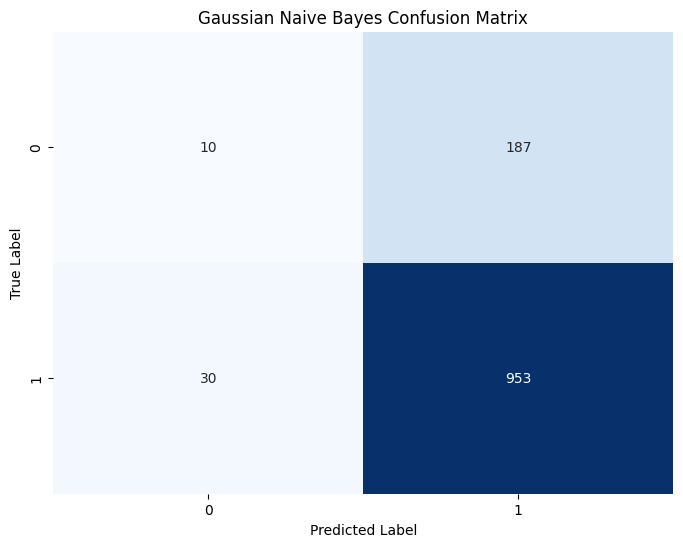

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'var_smoothing': np.logspace(0, -9, num=100)}
# Initialize the Gaussian Naive Bayes model
gnb_model = GaussianNB()

# Initialize GridSearchCV
grid_search = GridSearchCV(gnb_model, param_grid, cv=5, scoring='roc_auc')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
gnb_model = grid_search.best_estimator_

print("Best parameters found by GridSearchCV:")
print(best_params)

# Train the model
# gnb_model.fit(X_train, y_train)

# Make predictions
y_pred_gnb = gnb_model.predict(X_test)
y_pred_proba_gnb = gnb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
conf_matrix_gnb = confusion_matrix(y_test, y_pred_gnb)
precision_gnb = precision_score(y_test, y_pred_gnb, pos_label=1.0)
recall_gnb = recall_score(y_test, y_pred_gnb, pos_label=1.0)
f1_gnb = f1_score(y_test, y_pred_gnb, pos_label=1.0)
roc_auc_gnb = roc_auc_score(y_test, y_pred_proba_gnb)
class_report_gnb = classification_report(y_test, y_pred_gnb)

print("\nGaussian Naive Bayes Model Evaluation:")
print(f"Accuracy: {accuracy_gnb:.4f}")
print("Confusion Matrix:")
print(conf_matrix_gnb)
print(f"Precision: {precision_gnb:.4f}")
print(f"Recall: {recall_gnb:.4f}")
print(f"F1 Score: {f1_gnb:.4f}")
print(f"ROC AUC Score: {roc_auc_gnb:.4f}")
print("Classification Report:")
print(class_report_gnb)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gnb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Gaussian Naive Bayes Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\n--- Tuned Gaussian Naive Bayes Explanations (LIME and SHAP) ---")

# LIME Explanations for Tuned Gaussian Naive Bayes
explainer_gnb_model = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['0', '1'],
    discretize_continuous=True
)

def predict_fn_gnb_model(x):
    probs = gnb_model.predict_proba(x)
    return probs

exp_gnb_model = explainer_gnb_model.explain_instance(X_test.values[i], predict_fn_gnb_model, num_features=10)
print(f"\nLIME explanation for instance {i} (Gaussian Naive Bayes):")
exp_gnb_model.show_in_notebook(show_table=True, show_all=False)


## CatBoost


CatBoost Model Evaluation:
Accuracy: 0.7203
Confusion Matrix:
[[ 19 178]
 [152 831]]
Precision: 0.8236
Recall: 0.8454
F1 Score: 0.8343
ROC AUC Score: 0.4355
Classification Report:
              precision    recall  f1-score   support

         0.0       0.11      0.10      0.10       197
         1.0       0.82      0.85      0.83       983

    accuracy                           0.72      1180
   macro avg       0.47      0.47      0.47      1180
weighted avg       0.70      0.72      0.71      1180



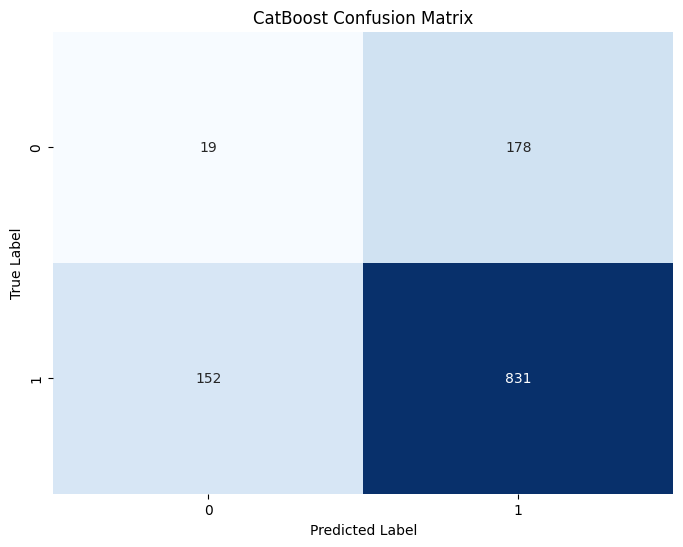


--- CatBoost Explanations (LIME and SHAP) ---

LIME explanation for instance 10 (CatBoost):


TypeError: CatBoost.get_feature_importance() got an unexpected keyword argument 'shap'

In [ ]:
# Initialize the CatBoost model
catboost_model = CatBoostClassifier(
    max_depth=6,
    random_state=42,
    n_estimators=1000,
    learning_rate=0.05,
    verbose=False,
    auto_class_weights='Balanced',
    allow_writing_files=False # Prevent CatBoost from writing files to disk
)

# Train the model
catboost_model.fit(X_train, y_train)

# Make predictions
y_pred_catboost = catboost_model.predict(X_test)
y_pred_proba_catboost = catboost_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
conf_matrix_catboost = confusion_matrix(y_test, y_pred_catboost)
precision_catboost = precision_score(y_test, y_pred_catboost, pos_label=1.0)
recall_catboost = recall_score(y_test, y_pred_catboost, pos_label=1.0)
f1_catboost = f1_score(y_test, y_pred_catboost, pos_label=1.0)
roc_auc_catboost = roc_auc_score(y_test, y_pred_proba_catboost)
class_report_catboost = classification_report(y_test, y_pred_catboost)

print("\nCatBoost Model Evaluation:")
print(f"Accuracy: {accuracy_catboost:.4f}")
print("Confusion Matrix:")
print(conf_matrix_catboost)
print(f"Precision: {precision_catboost:.4f}")
print(f"Recall: {recall_catboost:.4f}")
print(f"F1 Score: {f1_catboost:.4f}")
print(f"ROC AUC Score: {roc_auc_catboost:.4f}")
print("Classification Report:")
print(class_report_catboost)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_catboost, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('CatBoost Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\n--- CatBoost Explanations (LIME and SHAP) ---")

# LIME Explanations for CatBoost
explainer_catboost = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['0', '1'],
    discretize_continuous=True
)

def predict_fn_catboost(x):
    probs = catboost_model.predict_proba(x)
    return probs

exp_catboost = explainer_catboost.explain_instance(X_test.values[i], predict_fn_catboost, num_features=10)
print(f"\nLIME explanation for instance {i} (CatBoost):")
exp_catboost.show_in_notebook(show_table=True, show_all=False)

[I 2025-05-22 12:41:47,817] A new study created in memory with name: no-name-0344f9f9-e6c6-4100-a6a5-4c8d7acdf0dd
[I 2025-05-22 12:42:48,417] Trial 0 finished with value: 0.47105359641829886 and parameters: {'iterations': 2060, 'depth': 10, 'learning_rate': 0.044803926826840625, 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 8, 'max_bin': 146, 'bootstrap_type': 'Bernoulli', 'subsample': 0.737265320016441}. Best is trial 0 with value: 0.47105359641829886.
[I 2025-05-22 12:42:59,561] Trial 1 finished with value: 0.4951743084208189 and parameters: {'iterations': 396, 'depth': 10, 'learning_rate': 0.060534484680010825, 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 10, 'max_bin': 155, 'bootstrap_type': 'Bernoulli', 'subsample': 0.36210622617823773}. Best is trial 1 with value: 0.4951743084208189.
[I 2025-05-22 12:43:10,887] Trial 2 finished with value: 0.4303050332815219 and parameters: {'iterations': 3176, 'depth': 4, 'learning_rate': 0.011996621453406362, 'l2_leaf_r


Best parameters for CatBoost found by Optuna:
{'iterations': 396, 'depth': 10, 'learning_rate': 0.060534484680010825, 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 10, 'max_bin': 155, 'bootstrap_type': 'Bernoulli', 'subsample': 0.36210622617823773}
Best AUC score for CatBoost: 0.4952

Best CatBoost Model Evaluation:
Accuracy: 0.8161
Confusion Matrix:
[[  5 192]
 [ 25 958]]
Precision: 0.8330
Recall: 0.9746
F1 Score: 0.8983
ROC AUC Score: 0.4952
Classification Report:
              precision    recall  f1-score   support

         0.0       0.17      0.03      0.04       197
         1.0       0.83      0.97      0.90       983

    accuracy                           0.82      1180
   macro avg       0.50      0.50      0.47      1180
weighted avg       0.72      0.82      0.76      1180



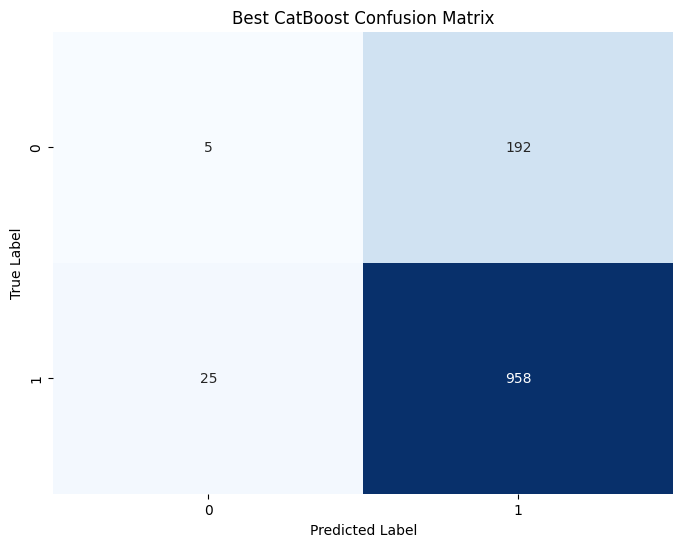


--- Best CatBoost Explanations (LIME and SHAP) ---

LIME explanation for instance 10 (Best CatBoost):


In [ ]:
def objective_catboost(trial):
  """Defines the objective function for Optuna optimization for CatBoost."""
  params = {
      # "iterations": trial.suggest_int("iterations", 300, 5000),
      # "depth": trial.suggest_int("depth", 3, 10),
      # "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
      # "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
      # "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
      # "max_bin": trial.suggest_int("max_bin", 64, 512),
      # "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
      'iterations': trial.suggest_int('iterations', 300, 5000),
      'depth': trial.suggest_int('depth', 3, 10),
      'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
      'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
      'max_bin': trial.suggest_int('max_bin', 100, 400),
      'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),

      "auto_class_weights": "SqrtBalanced",
      "eval_metric": "AUC",
      "random_state": 42,
      "verbose": False,
      "allow_writing_files": False
  }

  # Conditional parameters based on bootstrap_type
  if params["bootstrap_type"] == "Bayesian":
      params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
  elif params["bootstrap_type"] == "Bernoulli":
      params["subsample"] = trial.suggest_float("subsample", 0.1, 1)

  model = CatBoostClassifier(**params)
  model.fit(X_train, y_train)

  y_pred_proba = model.predict_proba(X_test)[:, 1]
  auc = roc_auc_score(y_test, y_pred_proba)

  return auc

# Create an Optuna study and optimize the objective function
study_catboost = optuna.create_study(direction="maximize",
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                                sampler=optuna.samplers.TPESampler(seed=42))

study_catboost.optimize(objective_catboost, n_trials=50)

# Print the best parameters and best AUC score
print("\nBest parameters for CatBoost found by Optuna:")
print(study_catboost.best_params)
print(f"Best AUC score for CatBoost: {study_catboost.best_value:.4f}")

# Train the CatBoost model with the best parameters
best_catboost_params = study_catboost.best_params
best_catboost_model = CatBoostClassifier(**best_catboost_params, auto_class_weights='SqrtBalanced',
                                        eval_metric='AUC', random_state=42, verbose=False,
                                        allow_writing_files=False)
best_catboost_model.fit(X_train, y_train)

# Evaluate the best CatBoost model
y_pred_best_catboost = best_catboost_model.predict(X_test)
y_pred_proba_best_catboost = best_catboost_model.predict_proba(X_test)[:, 1]

accuracy_best_catboost = accuracy_score(y_test, y_pred_best_catboost)
conf_matrix_best_catboost = confusion_matrix(y_test, y_pred_best_catboost)
precision_best_catboost = precision_score(y_test, y_pred_best_catboost, pos_label=1.0)
recall_best_catboost = recall_score(y_test, y_pred_best_catboost, pos_label=1.0)
f1_best_catboost = f1_score(y_test, y_pred_best_catboost, pos_label=1.0)
roc_auc_best_catboost = roc_auc_score(y_test, y_pred_proba_best_catboost)
class_report_best_catboost = classification_report(y_test, y_pred_best_catboost)

print("\nBest CatBoost Model Evaluation:")
print(f"Accuracy: {accuracy_best_catboost:.4f}")
print("Confusion Matrix:")
print(conf_matrix_best_catboost)
print(f"Precision: {precision_best_catboost:.4f}")
print(f"Recall: {recall_best_catboost:.4f}")
print(f"F1 Score: {f1_best_catboost:.4f}")
print(f"ROC AUC Score: {roc_auc_best_catboost:.4f}")
print("Classification Report:")
print(class_report_best_catboost)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_best_catboost, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Best CatBoost Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\n--- Best CatBoost Explanations (LIME and SHAP) ---")

# LIME Explanations for Best CatBoost
explainer_best_catboost = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['0', '1'],
    discretize_continuous=True
)

def predict_fn_best_catboost(x):
    probs = best_catboost_model.predict_proba(x)
    return probs

exp_best_catboost = explainer_best_catboost.explain_instance(X_test.values[i], predict_fn_best_catboost, num_features=10)
print(f"\nLIME explanation for instance {i} (Best CatBoost):")
exp_best_catboost.show_in_notebook(show_table=True, show_all=False)


## Ensemble Logistic Regression, Gnb and CatBoost


Ensemble Model Evaluation:
Accuracy: 0.8237
Confusion Matrix:
[[  3 194]
 [ 14 969]]
Precision: 0.8332
Recall: 0.9858
F1 Score: 0.9031
ROC AUC Score: 0.5268
Classification Report:
              precision    recall  f1-score   support

         0.0       0.18      0.02      0.03       197
         1.0       0.83      0.99      0.90       983

    accuracy                           0.82      1180
   macro avg       0.50      0.50      0.47      1180
weighted avg       0.72      0.82      0.76      1180



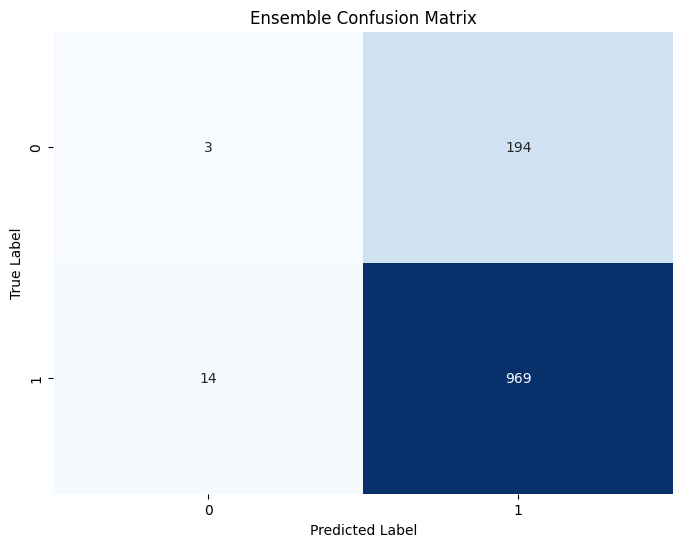


--- Ensemble Explanations (LIME) ---

LIME explanation for instance 10 (Ensemble):


In [ ]:
# Ensemble Model (Simple Averaging of Probabilities)
# Get predicted probabilities from each model on the test set
proba_log_reg = log_reg_model.predict_proba(X_test)[:, 1]
proba_gnb = gnb_model.predict_proba(X_test)[:, 1]
proba_catboost = best_catboost_model.predict_proba(X_test)[:, 1]

# Average the probabilities
ensemble_proba = (proba_log_reg + proba_gnb + proba_catboost) / 3

# Define a threshold (e.g., 0.5) to make final predictions
ensemble_pred = (ensemble_proba >= 0.5).astype(int)

# Evaluate the Ensemble model
accuracy_ensemble = accuracy_score(y_test, ensemble_pred)
conf_matrix_ensemble = confusion_matrix(y_test, ensemble_pred)
precision_ensemble = precision_score(y_test, ensemble_pred, pos_label=1.0)
recall_ensemble = recall_score(y_test, ensemble_pred, pos_label=1.0)
f1_ensemble = f1_score(y_test, ensemble_pred, pos_label=1.0)
roc_auc_ensemble = roc_auc_score(y_test, ensemble_proba)
class_report_ensemble = classification_report(y_test, ensemble_pred)

print("\nEnsemble Model Evaluation:")
print(f"Accuracy: {accuracy_ensemble:.4f}")
print("Confusion Matrix:")
print(conf_matrix_ensemble)
print(f"Precision: {precision_ensemble:.4f}")
print(f"Recall: {recall_ensemble:.4f}")
print(f"F1 Score: {f1_ensemble:.4f}")
print(f"ROC AUC Score: {roc_auc_ensemble:.4f}")
print("Classification Report:")
print(class_report_ensemble)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ensemble, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Ensemble Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\n--- Ensemble Explanations (LIME) ---")

# LIME Explanations for Ensemble (using average probability)
# Need a predict function that returns probabilities for LIME
def predict_fn_ensemble(x):
    # Ensure x has the same structure as X_test for each model
    x_df = pd.DataFrame(x, columns=X_test.columns)
    proba_lr = log_reg_model.predict_proba(x_df)[:, 1]
    proba_gnb = gnb_model.predict_proba(x_df)[:, 1]
    proba_cat = best_catboost_model.predict_proba(x_df)[:, 1]
    avg_proba = (proba_lr + proba_gnb + proba_cat) / 3
    # LIME expects probabilities for all classes
    # For binary classification, return shape (n_samples, 2)
    return np.vstack([1 - avg_proba, avg_proba]).T


explainer_ensemble = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['0', '1'],
    discretize_continuous=True,
    mode='classification' # Specify the mode
)

# Explain an instance using LIME for Ensemble
exp_ensemble = explainer_ensemble.explain_instance(X_test.values[i], predict_fn_ensemble, num_features=10)
print(f"\nLIME explanation for instance {i} (Ensemble):")
exp_ensemble.show_in_notebook(show_table=True, show_all=False)


--- Anomalies in column: id ---
count     5898.000000
mean     54964.183452
std      26133.640949
min      10002.000000
25%      32337.000000
50%      55501.000000
75%      77775.750000
max      99998.000000
Name: id, dtype: float64
------------------------------
--- Anomalies in column: gender ---
count    5898.000000
mean        0.910817
std         0.285032
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: gender, dtype: float64
------------------------------
--- Anomalies in column: married ---
count    5898.000000
mean        0.854527
std         0.352607
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: married, dtype: float64
------------------------------
--- Anomalies in column: education ---
count    5898.000000
mean        0.120210
std         0.325235
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000

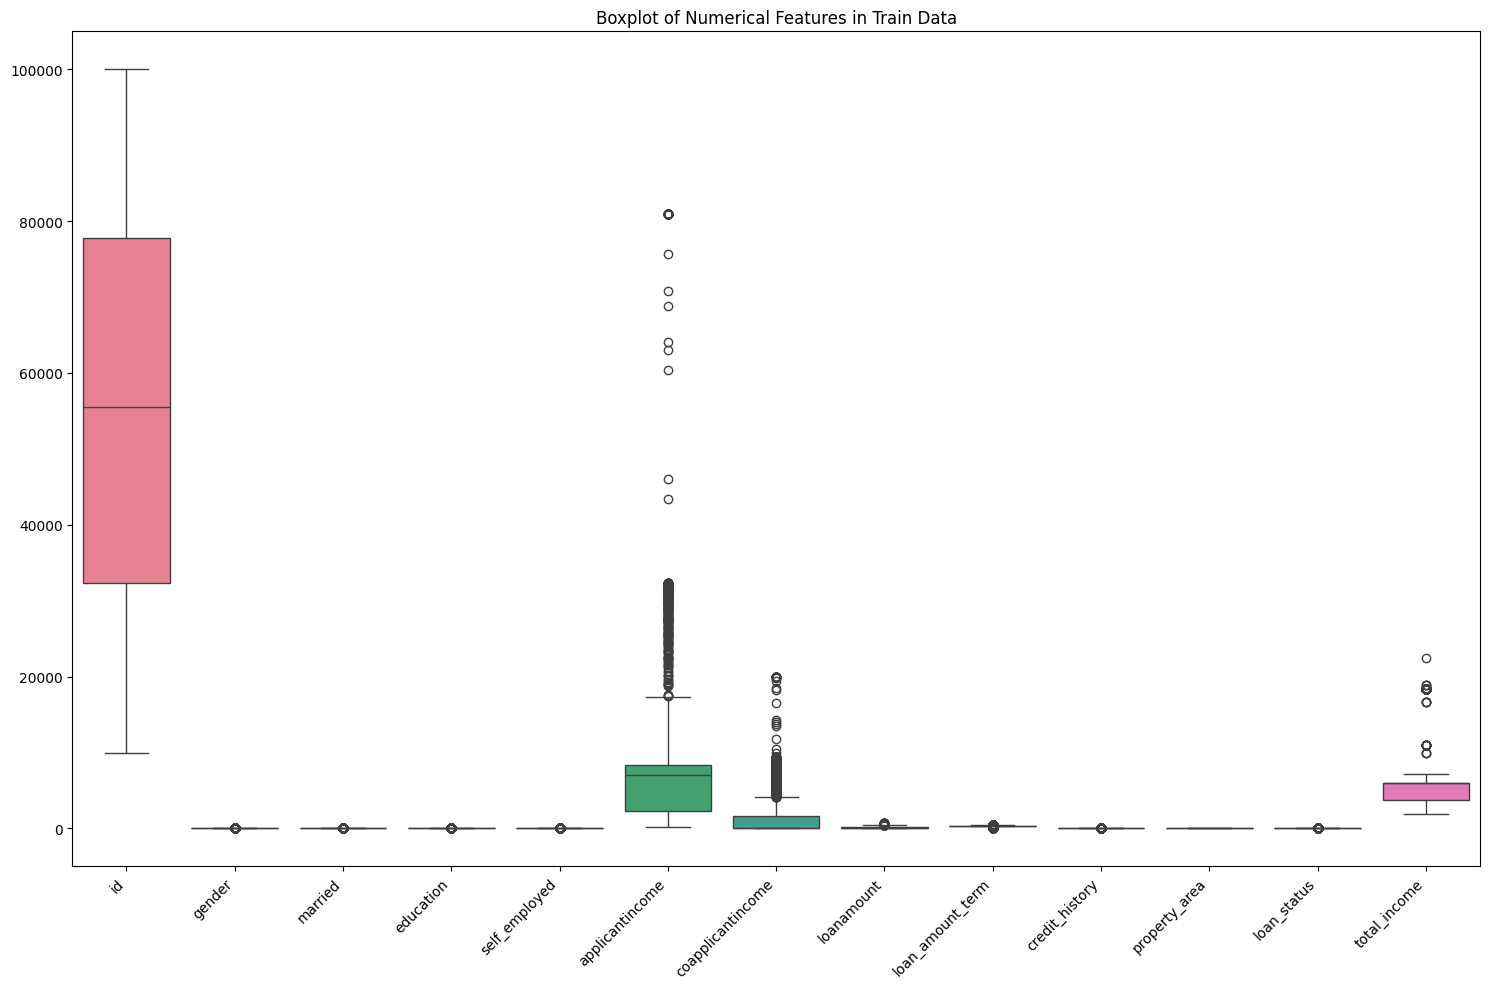

In [ ]:
# Select only numerical columns from train_df
numerical_cols = train_df.select_dtypes(include=np.number).columns

# Iterate through numerical columns and print summary statistics
for col in numerical_cols:
    print(f"--- Anomalies in column: {col} ---")
    print(train_df[col].describe())
    print("-" * 30)

# You can also use boxplots to visualize potential outliers
plt.figure(figsize=(15, 10))
sns.boxplot(data=train_df[numerical_cols])
plt.title('Boxplot of Numerical Features in Train Data')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
sns.countplot(x='loan_status', data=train_df)
plt.title('Target Variable Distribution')
plt.show()

In [ ]:
# Correlation matrix between features and target value
corr_matrix = X_train.corr()
plt.figure(figsize =(15,15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

print('correlations with target variables:/n', corr_matrix['loan_status'].sort_values(ascending=False))
# corr_matrix

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import AUC
!pip install lime shap keras-tuner

import keras_tuner as kt

Trial 90 Complete [00h 00m 40s]
val_f1_metric: 0.9084380865097046

Best val_f1_metric So Far: 0.908960223197937
Total elapsed time: 00h 22m 56s
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4299 - auc: 0.5175 - f1_metric: 0.5265 - loss: 0.1406 - val_accuracy: 0.7341 - val_auc: 0.4874 - val_f1_metric: 0.8371 - val_loss: 0.0563
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4559 - auc: 0.4954 - f1_metric: 0.5644 - loss: 0.1232 - val_accuracy: 0.7489 - val_auc: 0.5049 - val_f1_metric: 0.8487 - val_loss: 0.0579
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4815 - auc: 0.4893 - f1_metric: 0.5927 - loss: 0.1257 - val_accuracy: 0.7638 - val_auc: 0.5009 - val_f1_metric: 0.8595 - val_loss: 0.0586
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5069 - auc: 0.5172 - f1_metric: 0.6228 - loss: 0.1081 - val_accuracy: 0.7850 - val_auc: 0.4947 - val_f1_metric: 0.8754 - val_loss: 0.0573
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5463 - auc: 0.4960 - f1_metric: 0.6719 - loss: 0.1095 - val_accuracy: 0.8358 - val_auc: 0.4950 - val_f1_metric: 0.9077 - val_loss

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7009 - auc: 0.4874 - f1_metric: 0.8159 - loss: 0.1373 - val_accuracy: 0.6091 - val_auc: 0.4918 - val_f1_metric: 0.7376 - val_loss: 0.0956
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6625 - auc: 0.5353 - f1_metric: 0.7832 - loss: 0.0892 - val_accuracy: 0.7934 - val_auc: 0.5044 - val_f1_metric: 0.8803 - val_loss: 0.0577
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6028 - auc: 0.4885 - f1_metric: 0.7283 - loss: 0.0863 - val_accuracy: 0.8369 - val_auc: 0.4914 - val_f1_metric: 0.9084 - val_loss: 0.0571
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6392 - auc: 0.5066 - f1_metric: 0.7587 - loss: 0.0720 - val_accuracy: 0.8369 - val_auc: 0.4899 - val_f1_metric: 0.9084 - val_loss: 0.0588
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6446 - auc: 0.4773 - f1_metric: 0.7649 - loss: 0.0702 - val_accuracy: 0.8369 - val_auc: 0.4888 - val_f1_metric: 0.9084 - val_los

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6016 - auc: 0.5180 - f1_metric: 0.7070 - loss: 0.0963 - val_accuracy: 0.8369 - val_auc: 0.4849 - val_f1_metric: 0.9084 - val_loss: 0.0648
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8101 - auc: 0.5179 - f1_metric: 0.8925 - loss: 0.0576 - val_accuracy: 0.8369 - val_auc: 0.4757 - val_f1_metric: 0.9084 - val_loss: 0.0553
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8271 - auc: 0.5034 - f1_metric: 0.9032 - loss: 0.0558 - val_accuracy: 0.8369 - val_auc: 0.4812 - val_f1_metric: 0.9084 - val_loss: 0.0555
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8173 - auc: 0.4977 - f1_metric: 0.8975 - loss: 0.0558 - val_accuracy: 0.8369 - val_auc: 0.4857 - val_f1_metric: 0.9084 - val_loss: 0.0549
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8294 - auc: 0.4947 - f1_metric: 0.9051 - loss: 0.0557 - val_accuracy: 0.8369 - val_auc: 0.5080 - val_f1_metric: 0.9084 - val_loss

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6145 - auc: 0.4450 - f1_metric: 0.7454 - loss: 0.0869 - val_accuracy: 0.8369 - val_auc: 0.4831 - val_f1_metric: 0.9084 - val_loss: 0.0579
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7889 - auc: 0.5175 - f1_metric: 0.8773 - loss: 0.0574 - val_accuracy: 0.8210 - val_auc: 0.5026 - val_f1_metric: 0.8990 - val_loss: 0.0553
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7978 - auc: 0.4966 - f1_metric: 0.8840 - loss: 0.0575 - val_accuracy: 0.8369 - val_auc: 0.5110 - val_f1_metric: 0.9084 - val_loss: 0.0594
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8061 - auc: 0.4778 - f1_metric: 0.8902 - loss: 0.0579 - val_accuracy: 0.8369 - val_auc: 0.5167 - val_f1_metric: 0.9084 - val_loss: 0.0605
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8011 - auc: 0.4899 - f1_metric: 0.8871 - loss: 0.0588 - val_accuracy: 0.8273 - val_auc: 0.5058 - val_f1_metric: 0.9030

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5633 - auc: 0.4949 - f1_metric: 0.6882 - loss: 0.1345 - val_accuracy: 0.6917 - val_auc: 0.5131 - val_f1_metric: 0.8027 - val_loss: 0.0997
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5901 - auc: 0.4766 - f1_metric: 0.7200 - loss: 0.1058 - val_accuracy: 0.8347 - val_auc: 0.4765 - val_f1_metric: 0.9072 - val_loss: 0.0596
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6037 - auc: 0.5140 - f1_metric: 0.7268 - loss: 0.0832 - val_accuracy: 0.8294 - val_auc: 0.4923 - val_f1_metric: 0.9041 - val_loss: 0.0589
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6139 - auc: 0.4978 - f1_metric: 0.7388 - loss: 0.0782 - val_accuracy: 0.8369 - val_auc: 0.4846 - val_f1_metric: 0.9084 - val_loss: 0.0589
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6417 - auc: 0.4783 - f1_metric: 0.7679 - loss: 0.0730 - val_accuracy: 0.8369 - val_auc: 0.5026 - val_f1_metric: 0.9084 - val_loss

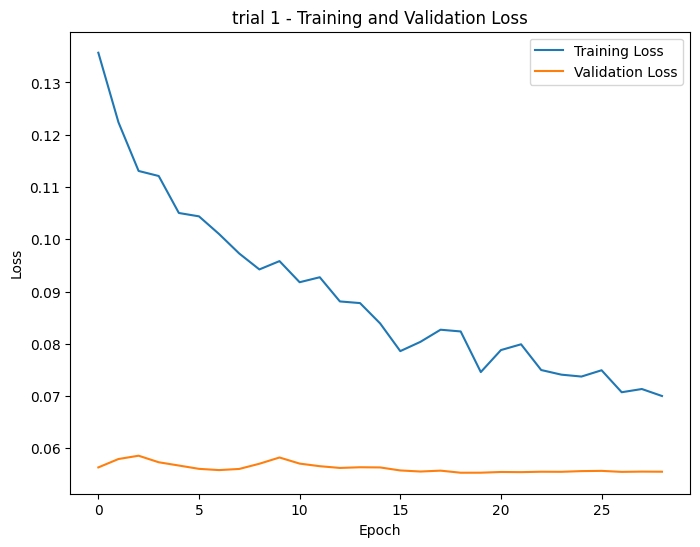

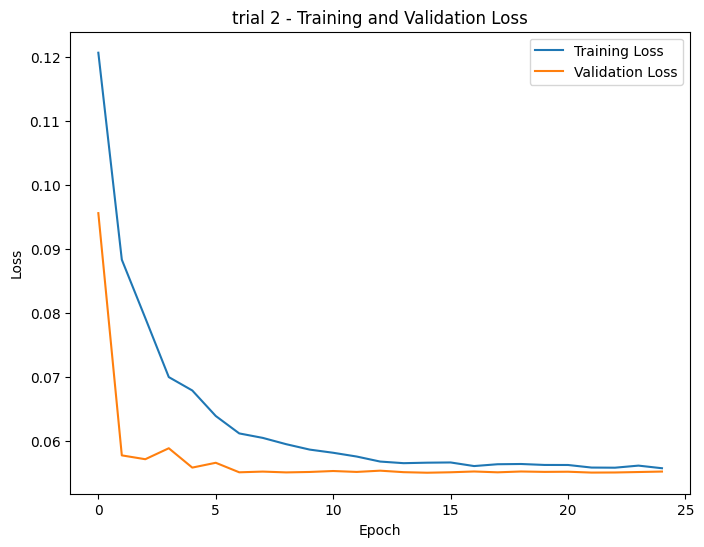

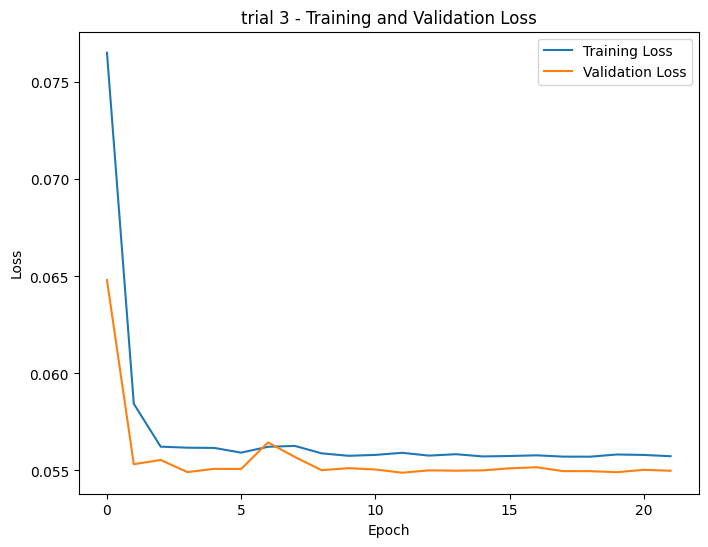

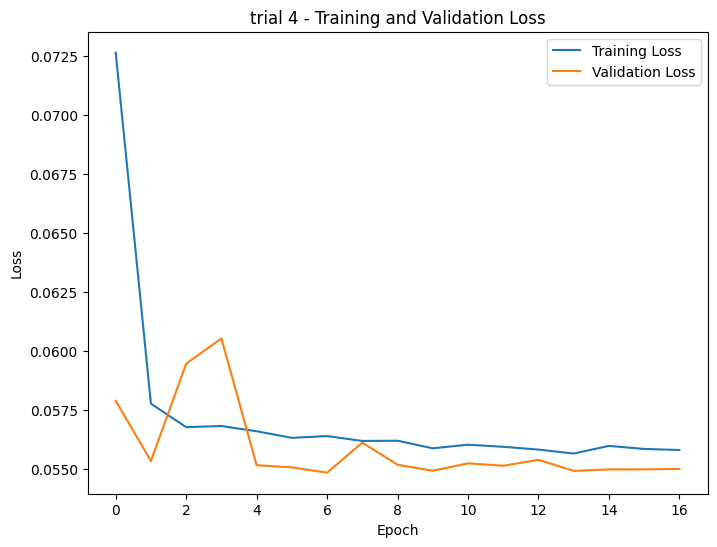

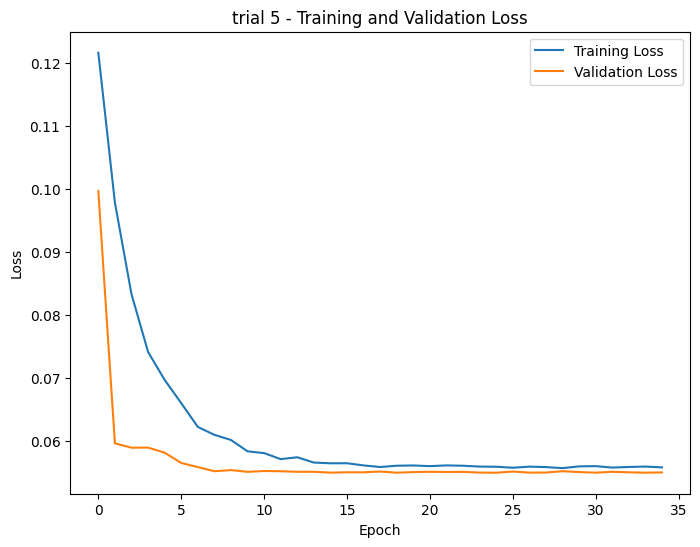

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Optimal threshold: 0.49615055


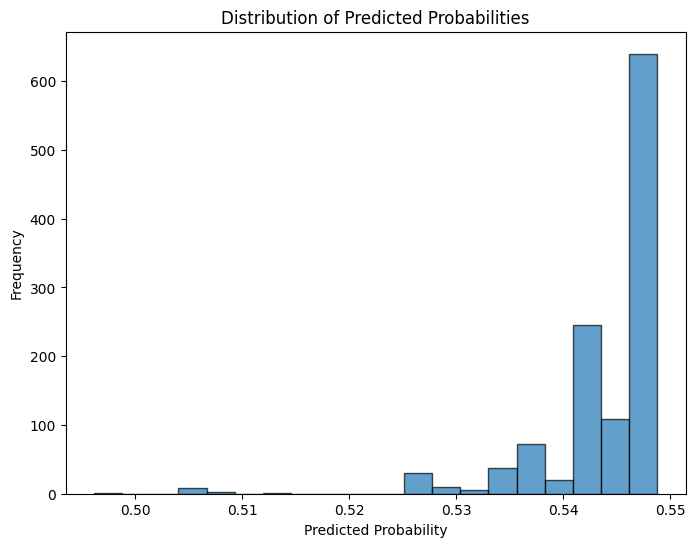

ROC AUC Score: 0.5486726120701675
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       197
         1.0       0.83      1.00      0.91       983

    accuracy                           0.83      1180
   macro avg       0.42      0.50      0.45      1180
weighted avg       0.69      0.83      0.76      1180



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


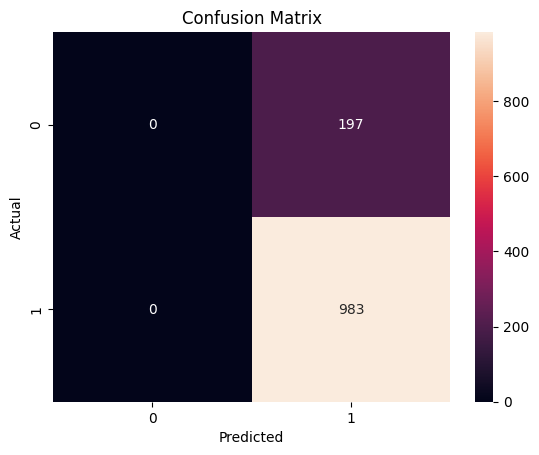

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-7, 1 - 1e-7)
        loss_val = -y_true * alpha * K.pow(1 - y_pred, gamma) * K.log(y_pred) - \
                   (1 - y_true) * (1 - alpha) * K.pow(y_pred, gamma) * K.log(1 - y_pred)
        return K.mean(loss_val)
    return loss

def f1_metric(y_true, y_pred):
    # Ensure y_true is a float32 tensor
    y_true = tf.cast(y_true, tf.float32)
    # Round predictions to 0 or 1 and cast to float32
    y_pred_binary = tf.cast(tf.greater_equal(y_pred, 0.5), tf.float32)

    tp = tf.reduce_sum(y_true * y_pred_binary)
    fp = tf.reduce_sum((1 - y_true) * y_pred_binary)
    fn = tf.reduce_sum(y_true * (1 - y_pred_binary))

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())

    return f1

# Define the model-building function for Keras Tuner
def model_builder(hp):
    model = Sequential()

    # Layer 1: Input layer
    model.add(Dense(units=hp.Int('units_1', min_value=64, max_value=256, step=32),
                    kernel_initializer='he_uniform',
                    input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    # Layer 2: Hidden layer
    model.add(Dense(units=hp.Int('units_2', min_value=64, max_value=256, step=32),
                    kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    # Layer 3: Additional hidden layer
    model.add(Dense(units=hp.Int('units_3', min_value=32, max_value=128, step=32),
                    kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Tunable learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Compile model with focal loss and balanced metrics (e.g., custom f1_metric)
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate, epsilon=1e-7),
                  loss=focal_loss(alpha=0.25, gamma=2.0),
                  metrics=['accuracy', AUC(name='auc'), f1_metric])

    return model

# Create a Keras Tuner instance
tuner = kt.Hyperband(
    model_builder,
    objective=kt.Objective("val_auc", direction="max"),
    max_epochs=50,
    directory='my_dir',
    project_name='loan_prediction_hyperband'
)

# tuner = kt.RandomSearch(
#     model_builder,
#     objective='val_accuracy',
#     max_trials=10,
#     directory='my_dir',
#     project_name='loan_prediction'
# )

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner.search(X_train, y_train,
             epochs=50,
             validation_split=0.2,
             callbacks=[early_stopping]
             )

# Retrieve best hyperparameters and train models
history_list = []
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]  # Get top 5 hyperparameter configurations
for hp in best_hps:
    model = tuner.hypermodel.build(hp)
    history = model.fit(X_train, y_train,
                        epochs=50,
                        validation_split=0.2,
                        callbacks=[early_stopping]
                        )
    history_list.append(history)


for i, history in enumerate(history_list):
  plt.figure(figsize=(8, 6))
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title(f'trial {i + 1} - Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()


# Predict on the test set
y_pred_prob = model.predict(X_test)
# y_pred = (y_pred_prob > 0.5).astype(int)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_prob)
f1_scores = 2 * precisions[:-1] * recalls[:-1] / (precisions[:-1] + recalls[:-1] + 1e-7)
best_threshold = thresholds[np.argmax(f1_scores)]
print("Optimal threshold:", best_threshold)

# Apply the best threshold to get final predictions
y_pred = (y_pred_prob >= best_threshold).astype(int)

plt.figure(figsize=(8, 6))
plt.hist(y_pred_prob, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.show()

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {roc_auc}")

# Print classification report
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['0', '1'],
    discretize_continuous=True
)

# Explain an instance using LIME
i = 10

# Wrap model.predict to return probabilities for both classes
def predict_fn(x):
    probs = model.predict(x)
    return np.hstack([1 - probs, probs])

exp = explainer.explain_instance(X_test.values[i], predict_fn, num_features=10)
exp.show_in_notebook(show_table=True, show_all=False)


# Initialize SHAP explainer
explainer = shap.Explainer(model, X_train)
shap_values = explainer(pd.DataFrame(X_test, columns=X_train.columns))

# Calculate SHAP values
# shap_values = explainer(X_test)
feature_importance = np.mean(np.abs(shap_values.values), axis=0)
feature_importance_df = pd.DataFrame({
       'Feature': X_test.columns,
       'Importance': feature_importance
   })
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (SHAP)')
plt.tight_layout()
plt.show()

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test)